# Principle Component Analysis as a Negative Control

Although FRESEAN allows us to use low-frequency vibrational modes as collective variables, we need to be able to verify that other COLVARs cannot generate the same results. Principle component analysis can be used to generate PCs that can be used as collective variables in metadynamics.

To run principle component analysis, we need to perform the following steps.
1. Generate a long vanilla MD simulation
2. Coarse grain the simulation
3. Generate the principle components
4. Convert to PLUMED format and rerun metadynamics

## Step 1 - Long vanilla MD Simulation

I ran a 1000 ns vanilla MD simulation of lysozyme using the following command.

```
sbatch FRESEANCOARSE/scripts/FRESEANCOARSE/scripts/MetaD_example_scripts/08-run_NPT-1000ns.sh
```

## Step 2 - Coarse Grain

Enter into the directory containing the microsecond trajectory and provide an input file similar to `FRESEANCOARSE/inp-files/01-coarse.inp`. Then you can run the following script, MAKING SURE TO UPDATE THE INPUT PARAMETERS!!!

```
sbatch FRESEANCOARSE/scripts/MetaD_example_scripts/04-coarse.sh
```
 
This script will run `fresean coarse` and then convert the coarse grained `.gro` trajectory into a `.trr` file, as well as generate a coarse grained topology and reference structure.

## Step 3 - Generate the principle components

Use `gmx covar` to generate the principle components.

```
gmx_plumed covar -f ctraj.trr -s cref.gro -o eigenval_FULL.xvg -v eigenvec_FULL.trr
```

## Step 4 - Metadynamics (SEE BOTTOM OF JUPYTER NOTEBOOK)

Convert the eigenvectors from `.trr` format into `.pdb format` and create a new PLUMED input file. Unfortunatly, these modes are still coarse grained. So we have to convert the coarsened modes into all atom modes. This can be done by converting the `.pdb` into `.xyz` and then using `fresean xyz2pdb` to convert back into PLUMED format. The format is described on the GITHUB docs as well as in `FRESEANCOARSE/scripts/MetaD_example_scriptss/06b-prep_plumed.sh`. Once the new PLUMED file is made, metadynamics can be run. 

<span style="color:red; font-size:5mm"> YOU HAVE TO CONVERT THE PDB TO XYZ BEFORE YOU CAN USE FRESEAN XYZ2PDB!! THIS IS DONE IN [THE LAST SECTION OF THIS NOTEBOOK](#another_cell) </span>.

In [1]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# Time is used to denote the different files that I used. 
# Importing in the eigenvalue files generated from 

time = 500000
time2 = 1000000
working_dir = "HEWL_counterion/PCA/"
PCA_eigval_D1 = pd.DataFrame(np.loadtxt(f'{working_dir}eigenval_{time}.xvg', dtype = float, comments=['#', '@'])[1:30,:], columns= ['PCA','First 500 NS'])
PCA_eigval_D1['Second 500 NS'] = np.loadtxt(f'{working_dir}eigenval_{time2}.xvg', dtype = float, comments=['#', '@'])[1:30,1]
#PCA_eigval_D1['Value2'] = np.sqrt((1.38E-23 * 300 * 6.626E34 * 3E-8 * 1E-2)/PCA_eigval_D1['Value2'])

# Plot PC Eigenvalues

We visualize the largest eigenvalues for the first and second 500 nanoseconds of the 1000 ns trajectory that I generated to compare the magnitudes. Not super useful but good to visualize. The eigenvalue is related to the frequency via the following equation (which would be better to plot). 

$$
\lambda_i = \frac{k_{b}T}{\omega_i}
$$


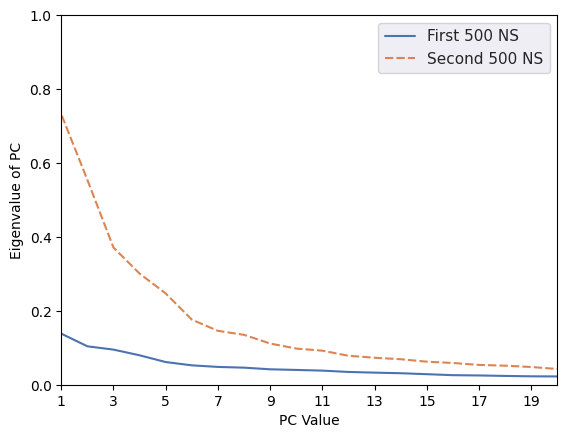

In [3]:
fig, ax = plt.subplots()
sns.set_theme()
sns.lineplot(data=PCA_eigval_D1[["First 500 NS", "Second 500 NS"]])
ax.set_xlim(1,20)
ax.set_ylim(0,1)
ax.set_xticks(range(1,20,2))
ax.set_xlabel("PC Value")
ax.set_ylabel("Eigenvalue of PC")
plt.show()

# Calculate and Plot Correlation of PCs

I was curious about how reproducable principle components are. I took my 1 microsecond trajectory and split it into 2 500 ns components. I then computed the principle components for each 500 ns fragment and I calculate the correlation. The correlation is jsut the dot product of the PC from the first trajectory and the PC from the second trajectory normalized by the magnitude of the vectors.

$$
Correlation_{i,j} = \frac{v_i \cdot w_j}{||v_i||||w_j||}
$$

<span style="color:red"> PLEASE PAY ATTENTION TO THE COLOR BAR RANGE! </span>.


In [4]:
DOF=246 # Number of atoms in your system
mode_range = 30 # Largest mode you wish to analyze

# First two pdbs are just average structures so offset loop by 2
EIGVEC_D1 = np.reshape(np.loadtxt(f'{working_dir}eigenvec_{time}.pdb', dtype=float, comments=['ENDMDL', 'REMARK', 'TITLE', 'MODEL', 'TER'], usecols=[5,6,7])[DOF*2:DOF*(mode_range+2),:], (mode_range,DOF*3))
EIGVEC_D2 = np.reshape(np.loadtxt(f'{working_dir}eigenvec_{time2}.pdb', dtype=float, comments=['ENDMDL', 'REMARK', 'TITLE', 'MODEL', 'TER'], usecols=[5,6,7])[DOF*2:DOF*(mode_range+2),:], (mode_range,DOF*3))

In [5]:
# Compute correlation

corr_val = [[np.abs(np.dot(EIGVEC_D1[i], EIGVEC_D2[j])/(np.linalg.norm(EIGVEC_D1[i])*np.linalg.norm(EIGVEC_D2[j]))) for i in range(mode_range)] for j in range(mode_range)]

<Figure size 800x800 with 0 Axes>

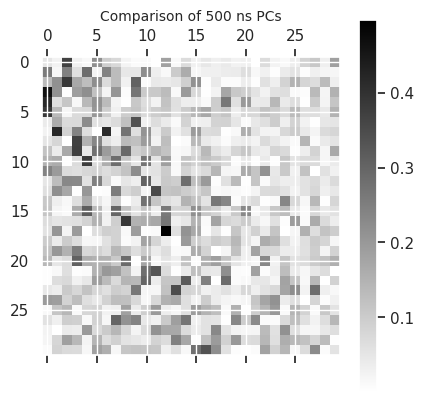

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
plt.matshow(corr_val, cmap='binary')
plt.title(f'Comparison of 500 ns PCs', fontsize=10)
plt.savefig("squares.png",dpi=250)
plt.colorbar()
plt.show()

# Step 4 - Metadynamics

<a id='another_cell'></a>

Here we take in the eigenvectors from `gmx covar` (which have been translated to `.pdb` format and convert it to `.xyz` format. Then we can use `fresean xyz2pdb -f inpfile` to convert our coarsened modes into all atom modes. An example inpfile is shown below.

```
#fnRef (gro reference structure generated from any coarsening)
ref.gro
#fnEig (file containing the xyz file generated here)
PC1.xyz
#nStart
1
#nEnd
1
#nRead
1
#fnOut
vec_1
```

The PLUMED format is just three pdb's concatenated onto each other. First pdb will be the reference structure used in metadynamics run, then the next two are the COLVARS. Example below. `REMARK TYPE=OPTIMAL` signifies the start of the reference structure and `REMARK TYPE=DIRECTION` signifies the start of the COLVAR.

```
1 REMARK TYPE=OPTIMAL
2 ATOM      1  N   LYS     0     285.600 434.200 504.300  1.00  0.00
...
1962 END
1963 REMARK TYPE=DIRECTION
1964 ATOM     1    N LYS     0      -0.034   0.449  -0.110  1.00  1.00           N
...
3923 ATOM  1960  OC2 LEU   128      -0.710  -0.770  -0.503  1.00  1.00           O
3924 END
```

In [7]:
# Load in data and convert from Angstroms to nanometers.

EIGVEC_FULL = np.reshape(np.loadtxt(f'{working_dir}eigenvec_FULL.pdb', dtype=float, comments=['ENDMDL', 'REMARK', 'TITLE', 'MODEL', 'TER'], usecols=[5,6,7])[:DOF*mode_range,:], (mode_range,DOF*3))
EIGVEC_FULL = EIGVEC_FULL/10

In [8]:
# Importing in the whole file so, be aware of index offset.
# Just set modeNum to whatever PC you want i.e PC 1 -> modeNum = 1

i=0
modeNum=2
with open(f"{working_dir}PC{modeNum}.xyz", "w") as writer:
    writer.write(f"{DOF}\nFrequency 1 Eigenvector 1\n")
    while i < 3*DOF:
        writer.write(f"X  {EIGVEC_FULL[modeNum+1,i]:15E}{EIGVEC_FULL[3,i+1]:15E}{EIGVEC_FULL[modeNum+1,i+2]:15E}\n")
        i=i+3